#Necessary imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import cv2
from google.colab.patches import cv2_imshow

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Dataset Initializaion

In [3]:
class UltrasoundDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        self.images = [img for img in self.images if os.path.exists(os.path.join(mask_dir, img.split('.')[0] + '_Annotation.png'))]
        print(f"Found {len(self.images)} valid image-mask pairs.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].split('.')[0] + '_Annotation.png')

        try:
            image = Image.open(img_path).convert("L")
            mask = Image.open(mask_path).convert("L")
        except IOError as e:
            print(f"Failed to load image or mask: {e}")
            return None

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

#Preprocessing Data

In [4]:
initial_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [5]:
image_dir = '/content/drive/MyDrive/Origin_Medical/Task - Segmentation/images'
mask_dir = '/content/drive/MyDrive/Origin_Medical/Task - Segmentation/masks'
dataset = UltrasoundDataset(image_dir, mask_dir, transform=initial_transform)

Found 622 valid image-mask pairs.


In [6]:
# Splitting the dataset
from torch.utils.data import DataLoader, Dataset, random_split
train_size = int(0.8 * len(dataset))  # 80% of the dataset for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [7]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
# def compute_mean_std(loader):
#     mean = 0.
#     std = 0.
#     total_images_count = 0

#     for images, _ in loader:
#         batch_samples = images.size(0)
#         images = images.view(batch_samples, images.size(1), -1)
#         mean += images.mean(2).sum(0)
#         std += images.std(2).sum(0)
#         total_images_count += batch_samples

#     mean /= total_images_count
#     std /= total_images_count

#     return mean.item(), std.item()

# # DataLoader setup
# train_loader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=4)

# # Calculate mean and standard deviation
# mean, std = compute_mean_std(train_loader)
# print(f'Mean: {mean}, Standard Deviation: {std}')

In [ ]:
# # Calculate mean and standard deviation
# mean, std = compute_mean_std(train_loader)
# print(f'Mean: {mean}, Standard Deviation: {std}')

# ##Mean: 0.16782093048095703, Standard Deviation: 0.16626697778701782

Mean: 0.16782091557979584, Standard Deviation: 0.16626696288585663


In [8]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # or any other size that you choose
    transforms.ToTensor(),
    #transforms.Normalize(mean=[mean], std=[std])
])

In [10]:
dataset = UltrasoundDataset(image_dir, mask_dir, transform=transform)

Found 622 valid image-mask pairs.


In [14]:
# check for one iteration of loop
for batch_x, batch_y in train_loader:
    break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [15]:
# get shapes of batches
batch_x.shape, batch_y.shape

(torch.Size([10, 1, 256, 256]), torch.Size([10, 1, 256, 256]))

#Model Definition

##Model_1

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            # Adjust mid_channels here after concatenation to handle the input channels correctly
            self.conv = DoubleConv(in_channels + in_channels // 2, out_channels, in_channels)  # in_channels + in_channels // 2 because of concatenation
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Handling the size mismatch
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)  # This causes the channel count to double
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class DUCKNet(nn.Module):
    def __init__(self, img_height, img_width, input_channels, out_classes, starting_filters, bilinear=True):
        super(DUCKNet, self).__init__()
        self.inc = DoubleConv(input_channels, starting_filters)
        self.down1 = Down(starting_filters, starting_filters * 2)
        self.down2 = Down(starting_filters * 2, starting_filters * 4)
        self.down3 = Down(starting_filters * 4, starting_filters * 8)
        self.down4 = Down(starting_filters * 8, starting_filters * 16)
        self.down5 = Down(starting_filters * 16, starting_filters * 32)

        self.up1 = Up(starting_filters * 32, starting_filters * 16, bilinear)
        self.up2 = Up(starting_filters * 16, starting_filters * 8, bilinear)
        self.up3 = Up(starting_filters * 8, starting_filters * 4, bilinear)
        self.up4 = Up(starting_filters * 4, starting_filters * 2, bilinear)
        self.up5 = Up(starting_filters * 2, starting_filters, bilinear)

        self.outc = OutConv(starting_filters, out_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)
        x = self.up1(x6, x5)
        x = self.up2(x, x4)
        x = self.up3(x, x3)
        x = self.up4(x, x2)
        x = self.up5(x, x1)
        logits = self.outc(x)
        return logits


In [18]:
# Assume the input images are 256x256 RGB images
img_height = 256
img_width = 256
input_channels = 1  # RGB images
out_classes = 1    # For example, 10 different classes
starting_filters = 64  # Number of filters in the first conv layer

model = DUCKNet(img_height, img_width, input_channels, out_classes, starting_filters)


In [19]:
print(model)

DUCKNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, mom

##Model_2.... referred from medium

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024 // (2 if bilinear else 1))
        self.up1 = Up(1024, 512 // (2 if bilinear else 1), bilinear)
        self.up2 = Up(512, 256 // (2 if bilinear else 1), bilinear)
        self.up3 = Up(256, 128 // (2 if bilinear else 1), bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [17]:
model = UNet(n_channels=1, n_classes=1)

In [18]:
print(model)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

# Start Training

In [20]:
#model = UNet(n_channels=1, n_classes=1)
model = DUCKNet(img_height, img_width, input_channels, out_classes, starting_filters)
if torch.cuda.is_available():
    model.cuda()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [21]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)


        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def train(model, train_loader, val_loader, optimizer, criterion, num_epochs, device):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss = validate(model, val_loader, criterion, device)


        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:

train_losses, val_losses = train(model, train_loader, val_loader, optimizer, criterion, num_epochs=25, device=device)


Epoch 1/25 - Train Loss: 0.2965, Val Loss: 0.1903
Epoch 2/25 - Train Loss: 0.1222, Val Loss: 0.0890
Epoch 3/25 - Train Loss: 0.0745, Val Loss: 0.0637
Epoch 4/25 - Train Loss: 0.0541, Val Loss: 0.0474
Epoch 5/25 - Train Loss: 0.0449, Val Loss: 0.0419
Epoch 6/25 - Train Loss: 0.0395, Val Loss: 0.0377
Epoch 7/25 - Train Loss: 0.0363, Val Loss: 0.0347
Epoch 8/25 - Train Loss: 0.0340, Val Loss: 0.0324
Epoch 9/25 - Train Loss: 0.0324, Val Loss: 0.0326
Epoch 10/25 - Train Loss: 0.0310, Val Loss: 0.0307
Epoch 11/25 - Train Loss: 0.0296, Val Loss: 0.0297
Epoch 12/25 - Train Loss: 0.0288, Val Loss: 0.0280
Epoch 13/25 - Train Loss: 0.0281, Val Loss: 0.0290
Epoch 14/25 - Train Loss: 0.0274, Val Loss: 0.0273
Epoch 15/25 - Train Loss: 0.0267, Val Loss: 0.0271
Epoch 16/25 - Train Loss: 0.0261, Val Loss: 0.0265
Epoch 17/25 - Train Loss: 0.0259, Val Loss: 0.0257
Epoch 18/25 - Train Loss: 0.0253, Val Loss: 0.0256
Epoch 19/25 - Train Loss: 0.0252, Val Loss: 0.0258
Epoch 20/25 - Train Loss: 0.0247, Val Lo

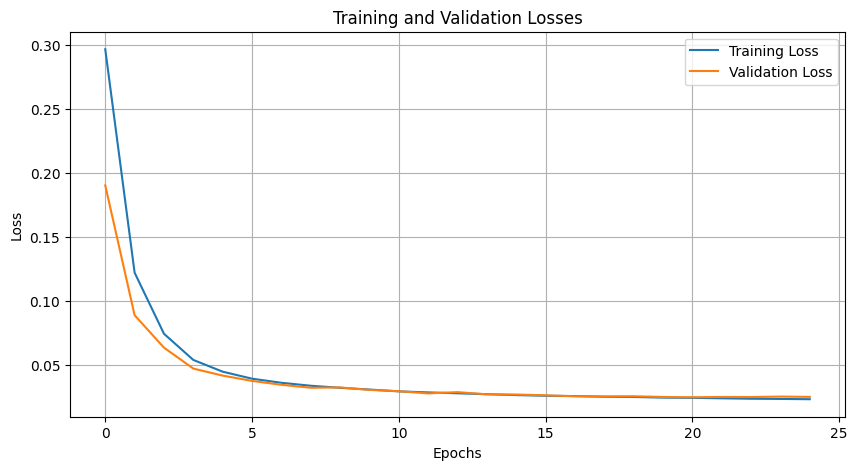

In [23]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_losses(train_losses, val_losses)


#Save Model weights

In [24]:
model_path = '/content/drive/MyDrive/Origin_Medical/duck_model_weights.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/Origin_Medical/duck_model_weights.pth


In [ ]:
state_dict = torch.load(model_path, map_location='cpu')

print("Loaded state_dict keys:")
print(state_dict.keys())

model = UNet(n_channels=1, n_classes=1)
print("\nExpected state_dict keys from the model definition:")
print(model.state_dict().keys())

Loaded state_dict keys:
odict_keys(['inc.double_conv.0.weight', 'inc.double_conv.0.bias', 'inc.double_conv.1.weight', 'inc.double_conv.1.bias', 'inc.double_conv.1.running_mean', 'inc.double_conv.1.running_var', 'inc.double_conv.1.num_batches_tracked', 'inc.double_conv.3.weight', 'inc.double_conv.3.bias', 'inc.double_conv.4.weight', 'inc.double_conv.4.bias', 'inc.double_conv.4.running_mean', 'inc.double_conv.4.running_var', 'inc.double_conv.4.num_batches_tracked', 'down1.maxpool_conv.1.double_conv.0.weight', 'down1.maxpool_conv.1.double_conv.0.bias', 'down1.maxpool_conv.1.double_conv.1.weight', 'down1.maxpool_conv.1.double_conv.1.bias', 'down1.maxpool_conv.1.double_conv.1.running_mean', 'down1.maxpool_conv.1.double_conv.1.running_var', 'down1.maxpool_conv.1.double_conv.1.num_batches_tracked', 'down1.maxpool_conv.1.double_conv.3.weight', 'down1.maxpool_conv.1.double_conv.3.bias', 'down1.maxpool_conv.1.double_conv.4.weight', 'down1.maxpool_conv.1.double_conv.4.bias', 'down1.maxpool_conv.1

In [ ]:
# model = UNet(n_channels=1, n_classes=1)#.to(device)
# model_path = '/content/drive/MyDrive/Origin_Medical/model_weights.pth'
# model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))

<All keys matched successfully>

# Visualize Initial Output

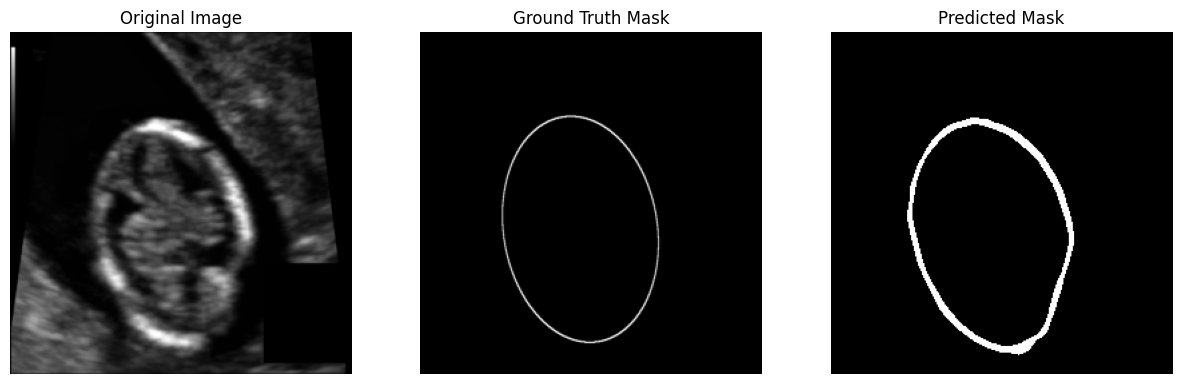

In [25]:

def visualize_segmentation(image, ground_truth, prediction, threshold=0.1):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image.squeeze(), cmap='gray')
    axes[0].set_title('Original Image')
    axes[1].imshow(ground_truth.squeeze(), cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[2].imshow(prediction.squeeze() > threshold, cmap='gray')
    axes[2].set_title('Predicted Mask')
    for ax in axes:
        ax.axis('off')
    plt.show()


model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        predictions = torch.sigmoid(outputs)


        visualize_segmentation(images[0].cpu(), masks[0].cpu(), predictions[0].cpu())
        break


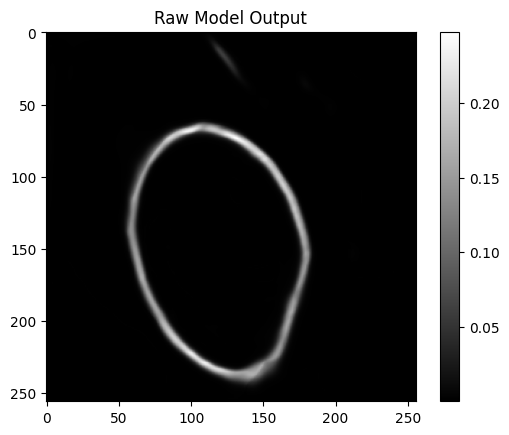

In [26]:


def visualize_predictions(output):
    plt.imshow(output.squeeze(), cmap='gray')
    plt.title('Raw Model Output')
    plt.colorbar()
    plt.show()

# Example usage within your evaluation loop
with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)
        outputs = model(images)
        predictions = torch.sigmoid(outputs)
        visualize_predictions(predictions[0].cpu())  # Visualizing the first image in the batch
        break


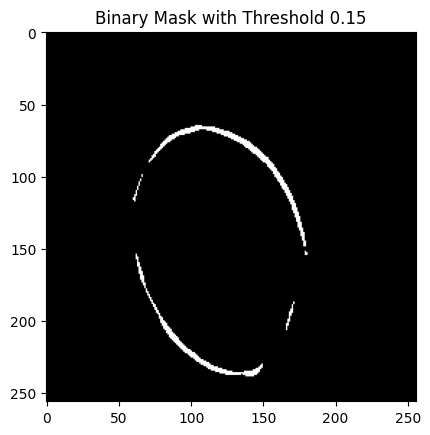

In [27]:
import matplotlib.pyplot as plt
import torch

def convert_to_binary_mask(output, threshold=0.15):
    binary_mask = output > threshold
    plt.imshow(binary_mask.squeeze(), cmap='gray')
    plt.title(f'Binary Mask with Threshold {threshold}')
    plt.show()

convert_to_binary_mask(predictions[0].cpu())


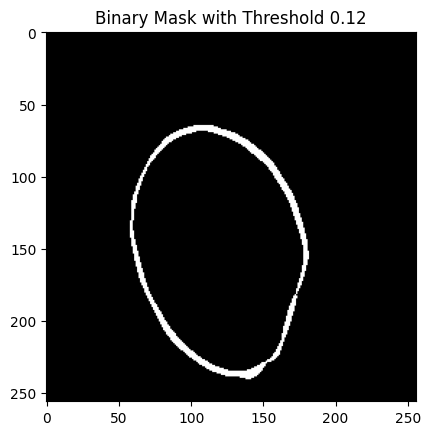

In [33]:
import matplotlib.pyplot as plt
import torch

def convert_to_binary_mask(output, threshold=0.12):
    binary_mask = output > threshold
    plt.imshow(binary_mask.squeeze(), cmap='gray')
    plt.title(f'Binary Mask with Threshold {threshold}')
    plt.show()

# Assuming 'predictions' is the output after sigmoid activation
convert_to_binary_mask(predictions[0].cpu())


In [ ]:
type(predictions)
print(predictions)

tensor([[[[0.0013, 0.0007, 0.0007,  ..., 0.0007, 0.0007, 0.0012],
          [0.0007, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0005],
          [0.0008, 0.0004, 0.0006,  ..., 0.0006, 0.0005, 0.0006],
          ...,
          [0.0006, 0.0003, 0.0004,  ..., 0.0005, 0.0004, 0.0006],
          [0.0008, 0.0005, 0.0005,  ..., 0.0004, 0.0003, 0.0006],
          [0.0006, 0.0005, 0.0004,  ..., 0.0008, 0.0007, 0.0011]]],


        [[[0.0013, 0.0007, 0.0007,  ..., 0.0007, 0.0007, 0.0012],
          [0.0007, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0005],
          [0.0008, 0.0004, 0.0006,  ..., 0.0006, 0.0005, 0.0006],
          ...,
          [0.0007, 0.0004, 0.0005,  ..., 0.0005, 0.0004, 0.0006],
          [0.0007, 0.0004, 0.0005,  ..., 0.0004, 0.0004, 0.0006],
          [0.0013, 0.0007, 0.0008,  ..., 0.0008, 0.0007, 0.0011]]],


        [[[0.0013, 0.0007, 0.0007,  ..., 0.0007, 0.0007, 0.0012],
          [0.0007, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0005],
          [0.0008, 0.0004, 0.0006,  ..

#Checking model Loading and prediction on val_set

In [10]:
img_height = 256
img_width = 256
input_channels = 1
out_classes = 1
starting_filters = 64

model = DUCKNet(img_height, img_width, input_channels, out_classes, starting_filters)

model_path = '/content/drive/MyDrive/Origin_Medical/duck_model_weights.pth'
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))

<All keys matched successfully>

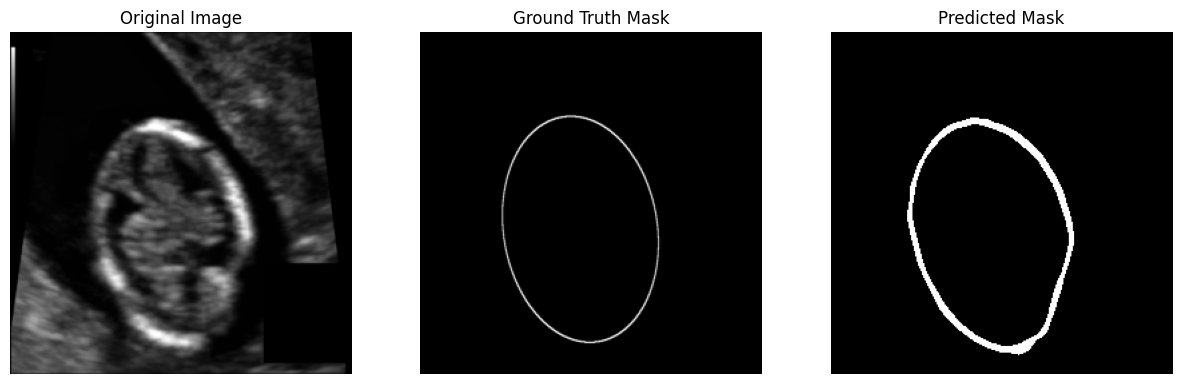

In [42]:

def visualize_segmentation(image, ground_truth, prediction, threshold=0.1):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image.squeeze(), cmap='gray')
    axes[0].set_title('Original Image')
    axes[1].imshow(ground_truth.squeeze(), cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[2].imshow(prediction.squeeze() > threshold, cmap='gray')  # Apply threshold
    axes[2].set_title('Predicted Mask')
    for ax in axes:
        ax.axis('off')
    plt.show()


model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        predictions = torch.sigmoid(outputs)

        visualize_segmentation(images[0].cpu(), masks[0].cpu(), predictions[0].cpu())
        break
